In [96]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [97]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using {} device".format(device))

Using cuda device


In [98]:


def load_data(dataset_path):
    data = []
    labels = []

    for folder in range(0,6):
        print("Cargando carpeta: ", folder)
        folder_path = os.path.join(dataset_path, str(folder))
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):
                complete_path = os.path.join(folder_path, filename)
                data.append(complete_path)
                labels.append(folder)  # Usa el nombre de la carpeta como etiqueta


    print("Número de archivos cargados: ", len(data))
    print("Número de etiquetas cargadas: ", len(labels))
    # Print cantidad de datos flac

    return data, labels




In [99]:
import imgaug.augmenters as iaa
import random

def augment_data(image_paths, labels, target_count=500):
    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(rotate=(-25, 25)),
        iaa.Multiply((0.8, 1.2)),
        iaa.GaussianBlur(sigma=(0, 3.0))
    ])

    augmented_images = []
    augmented_labels = []

    label_count = {i: labels.count(i) for i in set(labels)}

    for label, count in label_count.items():
        if count < target_count:
            needed = target_count - count
            label_indices = [i for i, l in enumerate(labels) if l == label]
            chosen_indices = random.choices(label_indices, k=needed)
            
            for idx in chosen_indices:
                image_path = image_paths[idx]
                image = Image.open(image_path)
                image_np = np.array(image)
                
                augmented_image_np = augmenter(image=image_np)
                augmented_image = Image.fromarray(augmented_image_np)
                
                augmented_image_path = f"{image_path}_aug_{idx}.jpg"
                augmented_image.save(augmented_image_path)
                
                augmented_images.append(augmented_image_path)
                augmented_labels.append(label)

    return augmented_images, augmented_labels


In [100]:
# Definir el Dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = image.resize((128, 128))
        
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [101]:
# Ruta del dataset
dataset_path = './data'

# Cargar datos y etiquetas
image_paths, labels = load_data(dataset_path)
augmented_image_paths, augmented_labels = augment_data(image_paths, labels, target_count=500)

# Añadir los datos aumentados a las listas originales
image_paths.extend(augmented_image_paths)
labels.extend(augmented_labels)

# Verificar el conteo final de datos por categoría
final_count = {i: labels.count(i) for i in set(labels)}
print("Conteo final de datos por categoría:", final_count)


Cargando carpeta:  0
Cargando carpeta:  1
Cargando carpeta:  2
Cargando carpeta:  3
Cargando carpeta:  4
Cargando carpeta:  5
Número de archivos cargados:  1637
Número de etiquetas cargadas:  1637
Conteo final de datos por categoría: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500}


In [102]:
from collections import Counter

# Contar las categorías
conteo = Counter(labels)
conteo

Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500})

In [103]:

# Dividir en entrenamiento y prueba 
train_data, test_data, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2)


# Definir transformaciones (puedes ajustarlas según tus necesidades)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalizar los valores de los pixeles a un rango de -1 a 1
])

# Crear una instancia del dataset
batch_size = 128

train_dataset = CustomImageDataset(train_data, train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomImageDataset(test_data, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset[0][0].shape)
print(train_dataset[0][1])


torch.Size([3, 128, 128])
tensor(1)


In [104]:


class ConvNet(nn.Module):
    def __init__(self,input_chanels,image_size,num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_chanels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.25)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(0.25)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        output_size = image_size // 2**4
        self.fc1 = nn.Linear(256 * output_size * output_size, 512)  # Assuming input image size is 128x128
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(x.size(0),-1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)



In [105]:
model = ConvNet(input_chanels=3,image_size=128,num_classes=6).to(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=51

In [106]:
def calculate_accuracy(y_true, y_pred):
    y_pred = torch.log_softmax(y_pred, dim=1)
    _, y_pred = torch.max(y_pred, dim=1)
    correct_pred = (y_true == y_pred).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    return accuracy

def train_single_epoch(model, data_loader, optimiser, device):
    model.train().to(device)
    losses = []
    accuracies = []
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # calculate output and loss
        prediction = model(input)
        prediction = prediction.to(device)
        loss = nn.CrossEntropyLoss()(prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        acc = calculate_accuracy(target, prediction)
        accuracies.append(acc.item())
        
    avg_acc = sum(accuracies) / len(accuracies)
    print(f"Training Accuracy: {avg_acc}")
    return avg_acc

def validate(model, data_loader, device):
    model.eval().to(device)
    accuracies = []
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)

            # calculate output
            prediction = model(input)
            acc = calculate_accuracy(target, prediction)
            accuracies.append(acc.item())
            
    avg_acc = sum(accuracies) / len(accuracies)
    print(f"Validation Accuracy: {avg_acc}")
    return avg_acc

def train(model, train_loader, valid_loader, optimiser, device, epochs):
    model.to(device)
    train_accuracies = []
    valid_accuracies = []
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_acc = train_single_epoch(model, train_loader, optimiser, device)
        valid_acc = validate(model, valid_loader, device)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        print("---------------------------")
    print("Finished training")

    # Plotting the learning curve
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.show()




Epoch 1
Training Accuracy: 0.3100328947368421
Validation Accuracy: 0.37954545617103574
---------------------------
Epoch 2
Training Accuracy: 0.4168037285930232
Validation Accuracy: 0.44133522510528567
---------------------------
Epoch 3
Training Accuracy: 0.5023300443824968
Validation Accuracy: 0.4723011374473572
---------------------------
Epoch 4
Training Accuracy: 0.5204221512141981
Validation Accuracy: 0.4836647748947144
---------------------------
Epoch 5
Training Accuracy: 0.5603070196352506
Validation Accuracy: 0.5764204621315002
---------------------------
Epoch 6
Training Accuracy: 0.5870339933194613
Validation Accuracy: 0.5752840995788574
---------------------------
Epoch 7
Training Accuracy: 0.601288378238678
Validation Accuracy: 0.6247159123420716
---------------------------
Epoch 8
Training Accuracy: 0.6207510985826191
Validation Accuracy: 0.6559659123420716
---------------------------
Epoch 9
Training Accuracy: 0.6376096512141981
Validation Accuracy: 0.6674715995788574
-

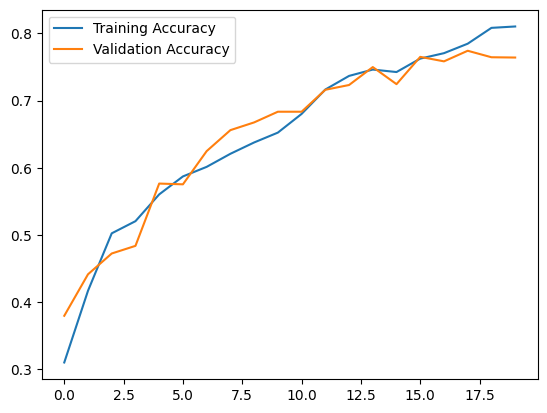

In [107]:
train(model, train_loader, test_loader, optimizer, device, epochs=20)

In [108]:
torch.save(model.state_dict(), 'hand_torch_modelv3.pth')

[[103   0   0   0   0   0]
 [  0  90  15   5   0   0]
 [  0  35  39  23   0   3]
 [  0   5   9  78   1   4]
 [  0   0   3  14  70  13]
 [  0   1   0   8   2  79]]


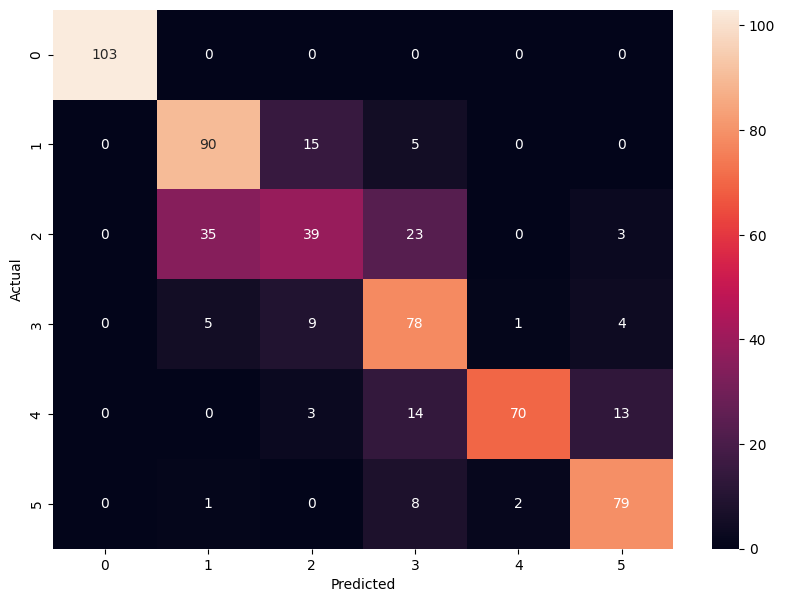

In [109]:


def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            prediction = model(input)
            _, prediction = torch.max(prediction, dim=1)
            predictions.extend(prediction.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels



predictions, true_labels = get_predictions(model, test_loader, device)
conf_matrix = confusion_matrix(true_labels, predictions)

print(conf_matrix)

labels = ["0", "1", "2", "3", "4", "5"]
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
